<a href="https://colab.research.google.com/github/baikunth2a/Lead-Score/blob/master/emp_score_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Google Drive File System

In [1]:
import pandas as pd
import sys
import os

from google.colab import drive
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/lead_gen')
%cd /content/gdrive/My\ Drive/lead_gen

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/lead_gen


##Loading relevant data 

In [2]:
excel_data = pd.read_excel('send_or_not.xlsx', sheet_name='13k')
excel_data.rename(columns={'SEND/NOT SEND':'send'}, inplace=True)
data_i = excel_data[excel_data['send'].apply(lambda x: x in ['SEND', 'NOT SEND'])]
data_i = data_i[['website', 'score' ,'no_of_employees','send']]

###Initial cleaning

In [4]:
def clean(url):
  url = url.replace(' ','')
  if not 'http' in url:
      return str('http://'+url).lower()
  else:
    return url

In [5]:
data_i['website'] = data_i['website'].dropna().apply(clean)

#Website ranking

In [6]:
w_score = pd.read_excel('Website_classifier/website_score.xlsx')

In [7]:
w_score.head(2)

,Unnamed: 0,url,score
0,0,http://cronosmonterrey.com/,8
1,1,http://www.filtronicssystems.com.mx,23


###Assigning the ranking value

In [8]:
import numpy as np
data_i['rank'] = np.nan
for website, score in zip(w_score['url'], w_score['score']):
  data_i['rank'].loc[data_i['website'] == website] = score
data_i['rank'].fillna(-10, inplace = True)
#data_i.dropna(inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


#Data Normalization

In [9]:
from sklearn import preprocessing
x = data_i[['rank']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data_i['rank'] = x_scaled
data_final = data_i[['no_of_employees', 'score' ,'rank', 'send']].dropna()

In [10]:
data_final.head(2)

,no_of_employees,score,rank,send
0,0 a 5 personas,13.0,0.000000,SEND
1,6 a 10 personas,8.0,0.370787,NOT SEND


In [11]:
data_final.shape

(1743, 4)

#Encoding features

###One hot

In [12]:
data = pd.get_dummies(data_final[['no_of_employees', 'rank', 'score']])
data['send'] = data_final['send'].astype('category').cat.codes

###Label

In [13]:
# data = data_final.copy()
# rep = {"no_of_employees": {"6 a 10 personas": 8, "0 a 5 personas": 3},
#                  "send": {"SEND": 1, "NOT SEND": 0},
#                  }
# data.replace(rep, inplace=True)

In [14]:
data.sample()

,rank,score,no_of_employees_0 a 5 personas,no_of_employees_6 a 10 personas,send
3013,0.764045,0.0,0,1,0


#Resample to make balanced dataset

In [15]:
from sklearn.utils import resample
df_majority = data[data.send==1]
df_minority = data[data.send==0]

###Upsample

In [16]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,
                                 n_samples=df_majority.shape[0],
                                 random_state=120)

df_sampled = pd.concat([df_majority, df_minority_upsampled])
df_sampled.send.value_counts()

1    1065
0    1065
Name: send, dtype: int64

###Downsample

In [17]:
# df_majority_down_sampled = resample(df_majority, 
#                                  replace=True,
#                                  n_samples=df_minority.shape[0],
#                                  random_state=120)

# df_sampled = pd.concat([df_minority, df_majority_down_sampled])
# df_sampled.send.value_counts()

###Unbalanced Dataset

In [18]:
X = data.values[:, :-1].astype(float)
y = data.values[:, -1].astype(float)

###Balanced Dataset

In [19]:
# X = df_sampled.values[:, :-1].astype(float)
# y = df_sampled.values[:, -1].astype(float)

#Decision Tree Classifier

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [22]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))

In [23]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

In [24]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)
clf.fit(X_train, y_train);

In [25]:
y_pred_i = clf.predict(X_test)

In [26]:
y_pred = [1 if yy>0.5 else 0 for yy in y_pred_i]

In [27]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7590822179732314


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


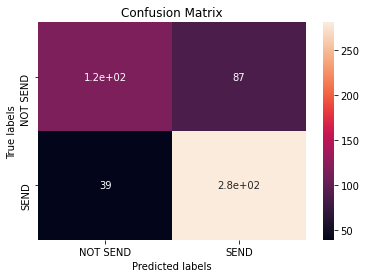

In [28]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt     
cm = metrics.confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); 
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['NOT SEND', 'SEND']); ax.yaxis.set_ticklabels(['NOT SEND', 'SEND']);

In [29]:
print(r2_score(y_test, y_pred_i))
print(mean_squared_error(y_test, y_pred_i))

0.2668031186664075
0.1741258492204855


In [30]:
joblib.dump(clf, 'em_score_rank.pkl')
# clf_open = joblib.load('rf_regressor.pkl')
# clf_open.predict(X_test)
# result = [1 if yy>0.5 else 0 for yy in clf_open.predict(X_test)]